# Data Analysis

## Setup

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.core.display_functions import display
from tqdm.auto import tqdm

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5, "lines.markersize": 8})

%matplotlib inline

## Load the data

In [2]:
import json

from lqam.methods.dataset import URL_DATA_TEST, URL_DATA_VAL
from lqam.util.file_utils import cached_path

with open(cached_path(URL_DATA_VAL)) as file:
    val_instances = json.load(file)

with open(cached_path(URL_DATA_TEST)) as file:
    test_instances = json.load(file)

instances = val_instances + test_instances

len(instances)

1985

Example instance:

In [3]:
instances[0]

{'video_id': 'cfBtVPEwqIo',
 'video_start_time': 5,
 'video_end_time': 15,
 'caption': 'In a gym with someone spotting him, a man is lifting weights performing squats in a squat rack.',
 'masked_caption': 'In a gym with someone spotting him, a man is lifting _____ performing squats in a squat rack.',
 'label': 'weights',
 'additional_answers': [['a weight', 'some weights', 'a squat bar'],
  ['weight', 'a bar'],
  ['weights', 'a barbell'],
  ['weights', 'a heavy load'],
  ['weights', 'a barbell'],
  ['weights', 'iron', 'equipment'],
  ['weights', 'a barbell', 'a weight'],
  ['weights', '405 lb']]}

In [4]:
for instance in instances:
    instance["id"] = f"{instance['video_id']}_{instance['video_start_time']}_{instance['video_end_time']}"

In [5]:
valid_instances = [instance for instance in instances if instance["additional_answers"]]
len(valid_instances)

1960

## Normalize the answers

In [6]:
from lqam.core.metrics import normalize_answer

for instance in instances:
    instance["label_norm"] = normalize_answer(instance["label"])
    instance["annotations_norm"] = [[normalize_answer(answer) for answer in worker_answers]
                                    for worker_answers in instance["additional_answers"]]

## Parse the data

In [7]:
import itertools

from lqam.annotations.metrics import SPACY_MODEL

doc_gen = SPACY_MODEL.pipe(text
                           for instance in instances
                           for text in itertools.chain([instance["caption"]],
                                                       (instance["masked_caption"].replace("_____", answer)
                                                        for worker_answers in instance["additional_answers"]
                                                        for answer in worker_answers)))

for instance in tqdm(instances):
    instance["parse_tree"] = next(doc_gen)

    start_idx = instance["masked_caption"].index("_____")
    instance["label_subtree"] = instance["parse_tree"].char_span(start_idx=start_idx,
                                                                 end_idx=start_idx + len(instance["label"]),
                                                                 alignment_mode="expand")

    instance["annotation_subtrees"] = [[doc.char_span(start_idx=start_idx, end_idx=start_idx + len(answer),
                                                      alignment_mode="expand")
                                        for answer, doc in zip(worker_answers, doc_gen)]
                                       for worker_answers in instance["additional_answers"]]

  0%|          | 0/1985 [00:00<?, ?it/s]

## Cases of "another person"

In [8]:
for instance in instances:
    if "another person" in {answer for worker_answers in instance["additional_answers"] for answer in worker_answers}:
        print(instance["masked_caption"])
        print(instance["label"])

A woman plays a flute while _____ is playing a harp instrument.
another woman
A man and _____ express happiness as they ride a sleigh down a hill.
a boy
On a road, a girl is pushing _____ sitting on a three-wheel wheelbarrow.
another girl
A man is seen doing sit-ups while his legs are held down by _____.
another person
A person is seen performing a back massage on _____.
an individual
A potter dits at his wheel as _____ slows and lift a pot off it and hands it to a woman sitting opposite him, as both pose for the camera.
it
A man has his name called by _____ on a microphone and stands to receive a bouqet of flowers.
someone
A person on a golf course hitting the ball into the hole in front of _____.
them
Music plays while a young woman shows her teeth, kisses _____ and shows picture collages.
another young woman
A small child bangs against a xylophone being held by _____.
a woman
A man is talking and _____ is stacking cards.
a boy
A teenage boy tosses a football at _____ who catches it 

## Distribution of the original answers vs. the annotated ones
Let's look at the top-K original answers and the top-K annotated answers.

In [9]:
original_answer_counts = pd.Series((instance["label_norm"] for instance in instances), name="Count").value_counts()
original_answer_counts.index.name = "Answer"
original_answer_counts.head(20)

Answer
man          113
person        56
woman         50
it            46
people        31
group         22
he            20
someone       19
boy           19
them          18
girl          17
front         17
young man     13
camera        13
table         12
piece         12
baby          11
ball          11
child         11
music         10
Name: Count, dtype: int64

In [10]:
annotated_answer_counts = pd.Series((answer
                                     for instance in instances
                                     for answer in {answer
                                                    for worker_answers in instance["annotations_norm"]
                                                    for answer in worker_answers}), name="Count").value_counts()
annotated_answer_counts.index.name = "Answer"
annotated_answer_counts.head(20)

Answer
person       409
man          310
guy          230
someone      226
woman        173
girl         156
people       152
boy          142
kid          132
male         129
lady         128
child        126
room          89
group         87
female        83
kids          79
it            76
human         73
gentleman     71
adult         62
Name: Count, dtype: int64

### Combine counts in a LaTeX table

In [11]:
combined_answer_counts = pd.concat([
    original_answer_counts.reset_index().head(10),
    annotated_answer_counts.reset_index().head(10),
], axis=1)
print(combined_answer_counts.style.hide().to_latex(hrules=True))

\begin{tabular}{lrlr}
\toprule
Answer & Count & Answer & Count \\
\midrule
man & 113 & person & 409 \\
person & 56 & man & 310 \\
woman & 50 & guy & 230 \\
it & 46 & someone & 226 \\
people & 31 & woman & 173 \\
group & 22 & girl & 156 \\
he & 20 & people & 152 \\
someone & 19 & boy & 142 \\
boy & 19 & kid & 132 \\
them & 18 & male & 129 \\
\bottomrule
\end{tabular}



### Plot the combined answer counts

In [12]:
combined_answer_frequencies_df = pd.concat([
    original_answer_counts / original_answer_counts.sum() * 100,
    annotated_answer_counts / annotated_answer_counts.sum() * 100,
], axis=1, keys=["Frequency in the original answers", "Frequency in the annotations"]).fillna(0.)

combined_answer_frequencies_df["Joint frequency"] = combined_answer_frequencies_df.mean(axis=1)
combined_answer_frequencies_df = combined_answer_frequencies_df.sort_values("Joint frequency", ascending=False)

top_answers = set(combined_answer_frequencies_df.head(20).index)

combined_answer_frequencies_df.head()

,Frequency in the original answers,Frequency in the annotations,Joint frequency
Answer,,,
man,5.692695,1.197235,3.444965
person,2.821159,1.579577,2.200368
woman,2.518892,0.668134,1.593513
it,2.317380,0.293516,1.305448
people,1.561713,0.587031,1.074372


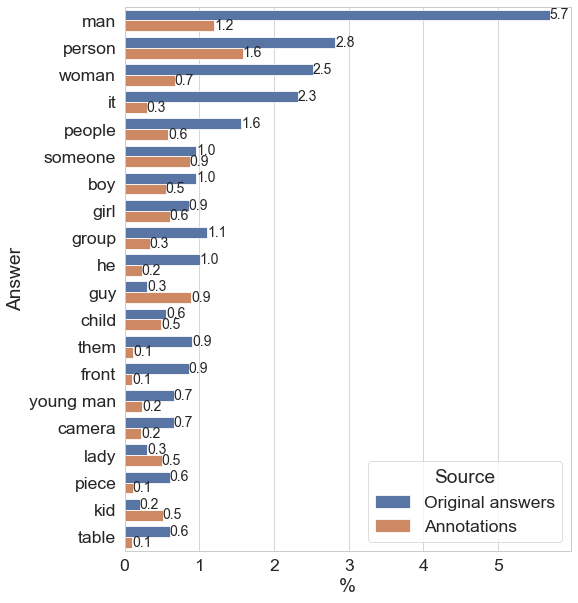

In [13]:
answer_flat_frequencies_df = combined_answer_frequencies_df.rename(
    columns={"Frequency in the original answers": "Original answers",
             "Frequency in the annotations": "Annotations"}
).melt(
    value_vars=["Original answers", "Annotations"], value_name="%",
    var_name="Source", ignore_index=False)

top_answer_flat_frequencies_df = answer_flat_frequencies_df[answer_flat_frequencies_df.index.isin(top_answers)]

plt.figure(figsize=(8, 10))
with sns.axes_style():
    sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 3, "lines.markersize": 10})

    ax = sns.barplot(data=top_answer_flat_frequencies_df, x="%", y=top_answer_flat_frequencies_df.index,
                     hue="Source")
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f", fontsize=14)

plt.gcf().savefig("label_annotation_top_NP_pcts.pdf", bbox_inches="tight")

### Plot both distributions

In [14]:
def plot_answer_distribution(answer_counts: pd.Series, plot_name: str) -> None:
    series = answer_counts.head(10).sort_values(ascending=False)
    sns.barplot(x=series, y=series.index, color="b").set_title(f"Top counts for the {plot_name}")

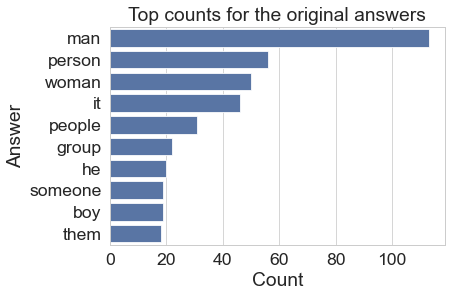

In [15]:
plot_answer_distribution(original_answer_counts, "original answers")

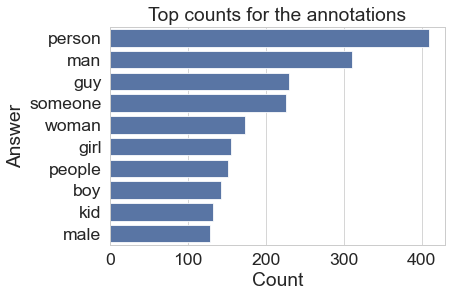

In [16]:
plot_answer_distribution(annotated_answer_counts, "annotations")

## Agreement between the original answers and the annotations
Which original phrases have lower/ higher agreement with the annotations?

In [17]:
from collections import Iterable
from lqam.core.metrics import compute_token_level_f1_many, tokenize_answer_to_compute_metrics  # noqa


def compute_original_answer_f1_score(label_: str, annotations_: Iterable[Iterable[str]]) -> float:
    original_answer_tokens_ = tokenize_answer_to_compute_metrics(normalize_answer(label_))
    annotation_tokens = (tokenize_answer_to_compute_metrics(normalize_answer(answer))
                         for annotation in annotations_
                         for answer in annotation)
    return compute_token_level_f1_many(original_answer_tokens_, annotation_tokens)

count    1960.000000
mean        0.840221
std         0.298881
min         0.000000
25%         0.666667
50%         1.000000
75%         1.000000
max         1.000000
Name: F1, dtype: float64

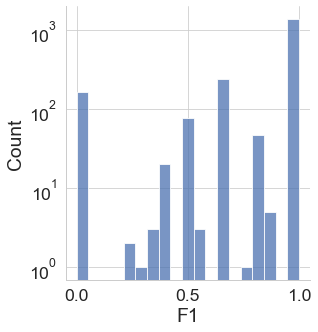

In [18]:
f1_scores_by_id = {instance["id"]: compute_original_answer_f1_score(instance["label_norm"],
                                                                    instance["annotations_norm"])
                   for instance in valid_instances}
f1_scores = pd.Series(f1_scores_by_id, index=f1_scores_by_id.keys(), name="F1")
sns.displot(f1_scores).set(yscale="log")
f1_scores.describe()

How many original answers have a 100% F1 with respect to the annotations?

In [19]:
(f1_scores == 1).mean()

0.7107142857142857

### What are the top/bottom original answers (unique) in F1 score?

Original answers with the highest F1 score:

In [20]:
valid_instances_original_answers = pd.Series((instance["label_norm"] for instance in valid_instances), name="Answer",
                                             index=[instance["id"] for instance in valid_instances])
original_answer_score_df = pd.concat([valid_instances_original_answers, f1_scores], axis=1)
original_answer_score_aggregate = original_answer_score_df.groupby("Answer").apply(lambda x: x.F1.mean()).sort_values(
    ascending=False)
original_answer_score_aggregate.head(20)

Answer
his shoes          1.0
slow motion        1.0
skillet            1.0
his ear            1.0
his family         1.0
his feet           1.0
his fingers        1.0
skies              1.0
ski resort         1.0
his foot           1.0
his goggles        1.0
his house          1.0
his inhaler        1.0
his knees          1.0
his leg            1.0
his living room    1.0
sit ups            1.0
his mouth          1.0
his neck           1.0
his dog            1.0
dtype: float64

Original answers with lowest F1 score:

In [21]:
original_answer_score_aggregate.sort_values(ascending=True).head(20)

Answer
45 degree angle             0.0
bangers                     0.0
back ground                 0.0
bongpipe                    0.0
axed device                 0.0
brunette                    0.0
building block formation    0.0
bulldozer                   0.0
buns                        0.0
cabinet shelf               0.0
wooden spoon                0.0
camo paint                  0.0
cement plaster              0.0
char                        0.0
choir                       0.0
choppy waters               0.0
circle                      0.0
clarinet                    0.0
colored oring               0.0
comment                     0.0
dtype: float64

The words with higher agreement tend to be simple and concrete nouns (`motorcycle`, `bat`).

The words with lower agreement tend to be highly specific (`45 degree angle`, `taekwondo`) or vague (`twos`, `time`).

## Tokens per answer
How many tokens on average does each answer contain?

We'll look at this for both the original answers and the annotations.

Original answers have 1.47 +/- 0.68 tokens.
Annotated answers have 1.36 +/- 0.68 tokens.


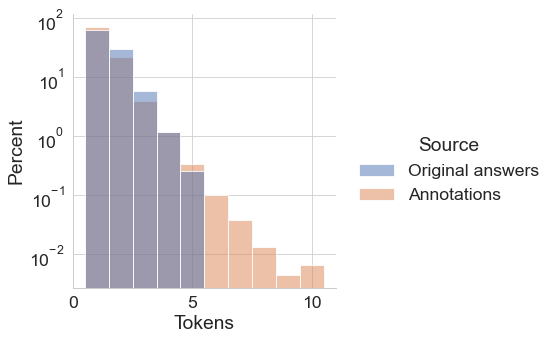

In [22]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

original_answers_df = pd.DataFrame(valid_instances_original_answers)
original_answers_df["Tokens"] = original_answers_df.Answer.apply(lambda answer: len(tokenizer.tokenize(answer)))

flat_annotations = [answer
                    for instance in valid_instances
                    for worker_answers in instance["annotations_norm"]
                    for answer in worker_answers
                    if answer]
annotations_df = pd.DataFrame({"Answer": flat_annotations})
annotations_df["Tokens"] = annotations_df.Answer.apply(lambda answer: len(tokenizer.tokenize(answer)))

original_answer_token_counts = original_answers_df["Tokens"]
annotation_answers_token_counts = annotations_df["Tokens"]

print(
    f"Original answers have {original_answer_token_counts.mean():.2f} +/- {original_answer_token_counts.std():.2f} tokens.")
print(
    f"Annotated answers have {annotation_answers_token_counts.mean():.2f} +/- {annotation_answers_token_counts.std():.2f} tokens.")

answers_df = pd.concat([
    original_answers_df.assign(Source="Original answers"),
    annotations_df.assign(Source="Annotations")
]).reset_index(drop=True)

sns.displot(answers_df, x="Tokens", hue="Source", discrete=True, stat="percent", common_norm=False).set(yscale="log")

### What are the longest answers in each set?

Longest original answers:

In [23]:
original_answers_sorted_df = original_answers_df.sort_values("Tokens", ascending=False)
original_answers_sorted_df = original_answers_sorted_df[~original_answers_sorted_df.index.duplicated()]
original_answers_sorted_df.head(20)

,Answer,Tokens
t-COcCPV-T4_20_30,black and white knitting kit,5
_Ex5WBnrN34_77_87,blue top and black trousers,5
By1lQRot9eo_35_45,innocent cute little baby boy,5
9d-ZXcIbYpk_94_104,loud and annoying music blares,5
_kQxazaUhMk_1_11,beautiful looking oil based painting,5
c8N9aqGstfg_132_142,jumbo chocolate chip cookies,4
31uPgVZtekA_149_159,ornately costumed dance squad,4
s8cxQ0a-KrE_152_162,strung out teenage girls,4
T_HXAfZDKdE_0_10,his messy computer desk,4
I7_PuNpdjXU_6_16,cows back end shows,4


Longest annotated answers:

In [24]:
annotations_sorted_df = annotations_df.sort_values("Tokens", ascending=False)
annotations_sorted_df = annotations_sorted_df[~annotations_sorted_df.index.duplicated()]
annotations_sorted_df.head(20)

,Answer,Tokens
36943,man who looks like to be in his mid 30s,10
19523,how she always has handful of dog food to start,10
21336,2 teams one in yellow jerseys and one white je...,10
18364,poor animal who needs its wool to stay warm,9
30254,man who looks like hes in his early 20s,9
15099,2 people total and 1 in full view,8
6628,boy in black and boy in blue tshirt,8
13188,cowboy wearing blue jeans and blue jean jacket,8
7111,male wearing shoes and black pants with stripes,8
7165,2 young kids with shorts and no shirts,8


The longest original answers tend to have multiple adjectives (`an innocent cute little baby boy`) and possessive markers (`his toy train set`).

The longest annotated answers tend to have coordination (`boy in black and boy in blue tshirt`) and long, unnecessary subclauses (`poor animal who needs it's wool to stay warm`).

### Chars per token
How long is each token? We expect that the tokens in the original answers will be slightly longer than the tokens for the annotations.

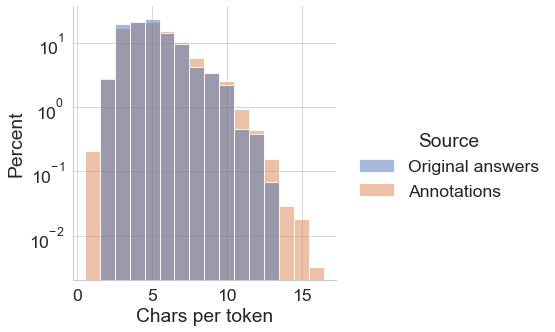

In [25]:
original_answer_token_chars = pd.Series((len(token)
                                         for answer in original_answers_df.Answer
                                         for token in tokenizer.tokenize(answer)), name="Chars per token")
annotation_answer_token_chars = pd.Series((len(token)
                                           for answer in annotations_df.Answer
                                           for token in tokenizer.tokenize(answer)), name="Chars per token")

answer_token_chars_df = pd.concat([
    pd.DataFrame(original_answer_token_chars).assign(Source="Original answers"),
    pd.DataFrame(annotation_answer_token_chars).assign(Source="Annotations")
]).reset_index(drop=True)

sns.displot(answer_token_chars_df, x="Chars per token", hue="Source", discrete=True, stat="percent",
            common_norm=False).set(yscale="log")

In [26]:
print(
    f"Original answer tokens have mean char len {original_answer_token_chars.mean():1.2f} +/- {original_answer_token_chars.std():1.2f}")
print(
    f"Annotations have mean char len {annotation_answer_token_chars.mean():1.2f} +/- {annotation_answer_token_chars.std():1.2f}")

Original answer tokens have mean char len 5.09 +/- 1.89
Annotations have mean char len 5.26 +/- 2.01


The annotations are slightly longer than the labels, due to the longer tail of extra-long tokens (annotator creativity?).

## Unique answers per question
How many unique answers does each question get?

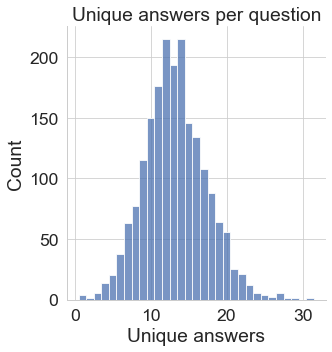

In [27]:
num_unique_answers_by_question = {instance["id"]: len({answer.lower()
                                                       for worker_answers in instance["annotations_norm"]
                                                       for answer in worker_answers})
                                  for instance in valid_instances}
num_unique_answers_per_question = pd.Series(num_unique_answers_by_question, index=num_unique_answers_by_question.keys(),
                                            name="Unique answers")
sns.displot(num_unique_answers_per_question, discrete=True).set(title="Unique answers per question")
plt.gcf().savefig("unique_answers_per_question.pdf", bbox_inches="tight")

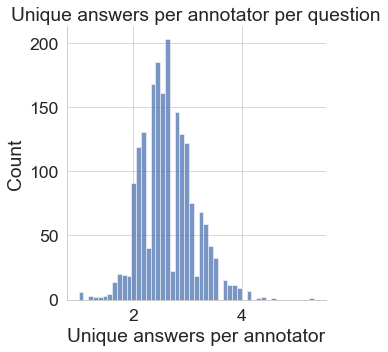

In [28]:
num_unique_answers_per_question_per_annotator = pd.Series(
    (sum(len({y.lower() for y in x}) for x in instance["annotations_norm"]) / len(instance["annotations_norm"])
     for instance in valid_instances), name="Unique answers per annotator")
sns.displot(num_unique_answers_per_question_per_annotator).set(title="Unique answers per annotator per question")
plt.gcf().savefig("unique_answers_per_annotator_per_question.pdf", bbox_inches="tight")

In [29]:
print(f"The questions have an average of {num_unique_answers_per_question.mean():.2f}"
      f" +/- {num_unique_answers_per_question.std():.2f} unique answers.")
print(f"The annotators have an average of {num_unique_answers_per_question_per_annotator.mean():.2f}"
      f" +/- {num_unique_answers_per_question_per_annotator.std():.2f} unique answers per question.")

The questions have an average of 13.21 +/- 4.07 unique answers.
The annotators have an average of 2.63 +/- 0.49 unique answers per question.


Most questions have around 13 unique labels total and 2.6 unique labels per annotator.

Is there a relationship between number of unique answers of a question, and it's agreement with the original phrase?

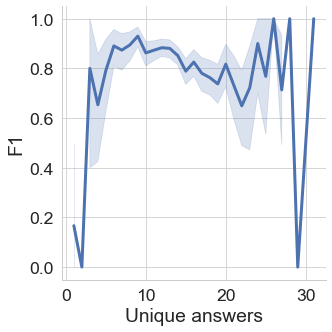

In [30]:
sns.relplot(data=pd.DataFrame(num_unique_answers_per_question).join(f1_scores), x="Unique answers", y="F1", kind="line")

### Inter-annotator agreement and the unique number of answers

Does the number of unique answers affect the inter-annotator agreement (leave-one-worker-out performance)?

In [31]:
from collections import defaultdict

from lqam.methods.metrics import F1ScoreMany

f1_score_by_instance = defaultdict(lambda: F1ScoreMany())

for instance in valid_instances:
    original_answer = instance["label_norm"]
    additional_answers = instance["annotations_norm"]
    for i in range(len(additional_answers)):
        first_worker_answer = additional_answers[i][0]
        rest = additional_answers[:i] + additional_answers[i + 1:]
        f1_score_by_instance[instance["id"]]([first_worker_answer], [original_answer], [rest])

f1_scores_inter = pd.Series((v.compute().item() for v in f1_score_by_instance.values()),
                            index=f1_score_by_instance.keys(), name="F1")

In [32]:
f1_scores_inter.mean()

0.8283176495598591

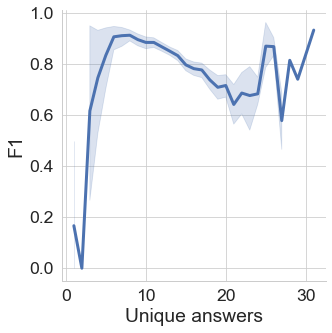

In [33]:
sns.relplot(data=pd.DataFrame(num_unique_answers_per_question).join(f1_scores_inter), x="Unique answers", y="F1",
            kind="line")

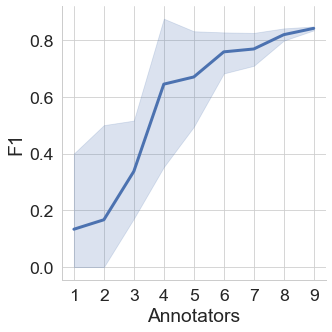

In [34]:
annotator_count = pd.Series((len(instance["annotations_norm"]) for instance in valid_instances),
                            index=(instance["id"] for instance in valid_instances), name="Annotators")
sns.relplot(data=pd.DataFrame(annotator_count).join(f1_scores_inter), x="Annotators", y="F1",
            kind="line").set(xticks=range(1, 10))
plt.gcf().savefig("human_performance_by_annotator_count.pdf", bbox_inches="tight")

### Questions with the highest number of unique answers per annotator

Which questions have the highest number of unique answers per annotator?

In [35]:
unique_answers_per_question_per_annotator_df = pd.DataFrame([
    (instance["masked_caption"] for instance in valid_instances),
    num_unique_answers_per_question_per_annotator,
    num_unique_answers_per_question,
], index=["prompt", "unique_label_count", "unique_labels"]).transpose()
unique_answers_per_question_per_annotator_df = unique_answers_per_question_per_annotator_df.sort_values(
    "unique_label_count", ascending=False)

with pd.option_context("display.max_colwidth", 200):
    display(unique_answers_per_question_per_annotator_df.head(10))

,prompt,unique_label_count,unique_labels
1545,_____ attempts to throw a snowball but it falls out of his hand.,5.333333,31
1546,_____ stands in front of a stone wall then jumps towards it and rebounds off it with his legs.,4.555556,25
1037,_____ have a pillow fight and then argue about only using pillows.,4.444444,25
1322,_____ demonstrates how to unlock and open a window.,4.375,24
936,_____ kicks soccer balls into a net while on a grass field.,4.333333,20
590,_____ peels a potato with an extra large peeler than can also be used on zucchini.,4.125,16
428,A group of _____ in pink tutus dancing in a circle on stage.,4.111111,14
261,A man is walking by _____ that is completely full then comes back and smashes the computer monitor sitting on top with a baseball bat.,4.111111,26
577,_____ plays an instrument while wearing a pink shirt.,4.111111,19
606,_____ is styling a person's hair using a blow dryer and brush.,4.111111,17


Questions with the lowest number of unique answers per annotator:

In [36]:
with pd.option_context("display.max_colwidth", 200):
    display(unique_answers_per_question_per_annotator_df.tail(10))

,prompt,unique_label_count,unique_labels
721,A young boy who seems to be timing _____ how fast he can eat a snack.,1.285714,6
706,Packages of paper are being wrapped in paper plastic and stacked on _____ of each other.,1.25,5
1007,"A group of people are riding donkeys, some people are riding and _____ are just standing by them.",1.25,3
1014,A shirtless person lifts a barbell and _____ at a gym.,1.25,3
847,A person is showing how _____ open a beer with a screw driver indoors.,1.0,4
989,A pair of bikers drive around _____ sphere as the crowd cheers them.,1.0,1
1686,A child is _____ and does not seem to be happy about it.,1.0,1
1169,A woman with _____ her face with a towel.,1.0,1
1225,A woman is exercising with dumb bells and another woman whispers _____.,1.0,3
142,A baby is listening to a lady's song as _____.,1.0,1


Questions with a higher number of unique answers seem to inspire creative answers (`____ kicks soccer balls into a net` => different paraphrases for `player`) and address multiple possible aspects of an event due to ambiguity (`____ are each wrapping` => different configurations of children).

Questions with a lower number of unique answers seem to have very specific scenarios without room for paraphrasing or ambiguity (`___ at gym` => can only add `weights` as logical caption).

## Assessing visual cues
Some nouns and adjectives have more obvious visual cues than others, ex. "green" has clear visual component whereas "kind" is more subjective.

Let's look for these visual cues in the original answers and annotations using some word lists:
- color
- size
- number

In [37]:
# TODO: expand word sets using word embeddings (nearest neighbors + filtering)
color_words = {"red", "blue", "green", "yellow", "purple", "orange", "black",
               "white", "gray", "grey", "colorful", "painted"}
size_words = {"large", "huge", "giant", "small", "little", "tiny"}
number_words = {"one", "two", "three", "four", "five", "six", "seven", "eight",
                "nine", "ten", "several", "few", "many"}
combined_visual_words = color_words | size_words | number_words

visual_word_sets = [color_words, size_words, number_words, combined_visual_words]
visual_word_set_names = ["color", "size", "number", "combined"]

In [38]:
from lqam.core.metrics import tokenize_answer_to_compute_metrics

original_answer_tokens = [tokenize_answer_to_compute_metrics(instance["label_norm"]) for instance in instances]
annotations_tokens = [[tokenize_answer_to_compute_metrics(answer) for answer in worker_answers]
                      for instance in valid_instances
                      for worker_answers in instance["annotations_norm"]]

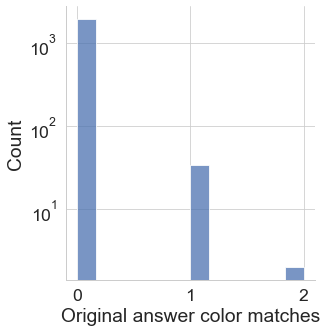

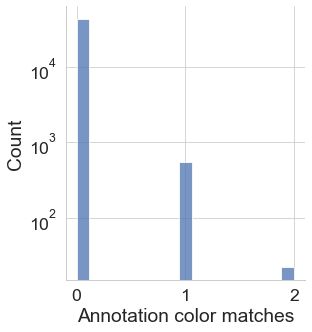

proportion of <color> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.981864                   0.987300
1           1              0.017128                   0.012211
2           2              0.001008                   0.000489
percent of labels with >= 1 matches: 
label_word_match_pct         0.018136
annotation_word_match_pct    0.012700
dtype: float64


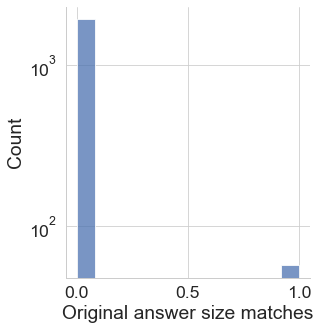

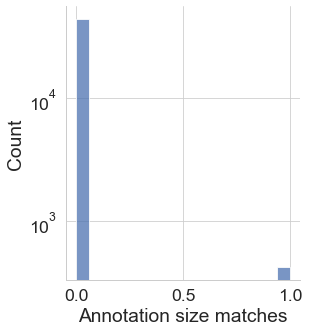

proportion of <size> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.971285                   0.990547
1           1              0.028715                   0.009453
percent of labels with >= 1 matches: 
label_word_match_pct         0.028715
annotation_word_match_pct    0.009453
dtype: float64


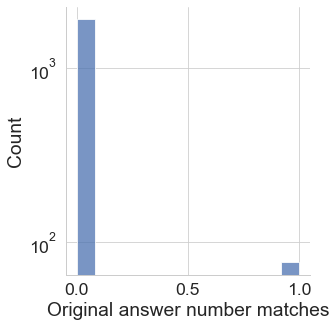

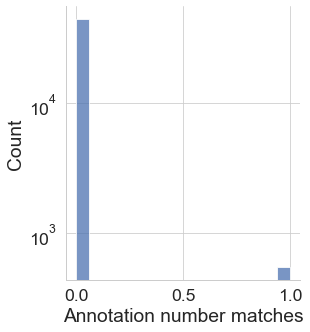

proportion of <number> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.961713                   0.987834
1           1              0.038287                   0.012166
percent of labels with >= 1 matches: 
label_word_match_pct         0.038287
annotation_word_match_pct    0.012166
dtype: float64


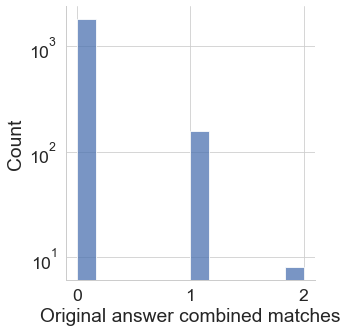

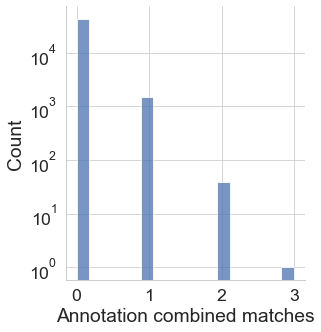

proportion of <combined> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.917884                   0.966103
1           1              0.078086                   0.033007
2           2              0.004030                   0.000867
3           3              0.000000                   0.000022
percent of labels with >= 1 matches: 
label_word_match_pct         0.082116
annotation_word_match_pct    0.033897
dtype: float64


In [39]:
for visual_word_set, visual_word_set_name in zip(visual_word_sets, visual_word_set_names):
    original_answer_matches = [set(answer) & visual_word_set for answer in original_answer_tokens]
    annotation_matches = [set(answer) & visual_word_set for worker_answers in annotations_tokens for answer in
                          worker_answers]

    num_original_answer_matches = pd.Series((len(match) for match in original_answer_matches),
                                            name=f"Original answer {visual_word_set_name} matches")
    num_annotation_matches = pd.Series((len(match) for match in annotation_matches),
                                       name=f"Annotation {visual_word_set_name} matches")

    sns.displot(num_original_answer_matches).set(yscale="log")
    plt.show()

    sns.displot(num_annotation_matches).set(yscale="log")
    plt.show()

    # compute proportion of visual words per question
    pct_original_answer_matches = pd.Series(num_original_answer_matches).value_counts() / len(
        num_original_answer_matches)
    pct_annotation_matches = pd.Series(num_annotation_matches).value_counts() / len(num_annotation_matches)
    pct_word_matches = pd.concat([pct_original_answer_matches, pct_annotation_matches], axis=1).reset_index().fillna(0.)
    pct_word_matches.columns = ["word_count", "label_word_match_pct", "annotation_word_match_pct"]

    print(f"proportion of <{visual_word_set_name}> word matches for labels:\n{pct_word_matches}")

    above_1_pct_word_matches = pct_word_matches[pct_word_matches.loc[:, "word_count"] >= 1].iloc[:, 1:].sum(axis=0)
    print(f"percent of labels with >= 1 matches: \n{above_1_pct_word_matches}")

Overall, the annotations tend to have about the rate of color words as the labels, but the annotations also have fewer size and number words than the labels.

What are some example questions where the label contains a visual word but the annotations do not?

In [40]:
valid_original_answer_tokens = [tokenize_answer_to_compute_metrics(instance["label_norm"]) for instance in
                                valid_instances]
valid_annotations_tokens = [[tokenize_answer_to_compute_metrics(answer)
                             for worker_answers in instance["annotations_norm"]
                             for answer in worker_answers]
                            for instance in valid_instances]

valid_annotations_tokens = [[token for answer in instance_answers for token in answer]
                            for instance_answers in valid_annotations_tokens]

for visual_word_set, visual_word_set_name in zip(visual_word_sets, visual_word_set_names):
    print(f"*~*~*~* testing word set {visual_word_set_name} *~*~*~*")

    original_answer_matches = [set(answer) & visual_word_set for answer in valid_original_answer_tokens]
    annotation_matches = [set(answer) & visual_word_set for answer in valid_annotations_tokens]

    for i, (instance, instance_original_answer_match, instance_annotation_answers_match) in enumerate(
            zip(valid_instances,
                original_answer_matches,
                annotation_matches)):
        if instance_original_answer_match and not instance_annotation_answers_match:
            print(f"caption=<{instance['caption']}>")
            print(f"label=<{instance['label']}> has matches <{instance_original_answer_match}>")
            print(f"annotations do not have matches: <{instance['additional_answers']}>")
            print("---------")

            if i >= 10:
                break

*~*~*~* testing word set color *~*~*~*
caption=<A red hot piece of bent steel is being formed with a metal sledge hammer on the end of a  steel table.>
label=<A red hot piece> has matches <{'red'}>
annotations do not have matches: <[['A horseshoe', 'A shoe', 'An arch', 'A U-shape', 'An object'], ['A piece', 'A horseshoe'], ['a rod', 'a segment'], ['hot iron'], ['A large are', 'A big area'], ['A piece', 'A long piece', 'A hot piece'], ['A piece', 'A rod', 'A chunk'], ['A piece', 'A part'], ['A piece', 'A heated piece']]>
---------
*~*~*~* testing word set size *~*~*~*
caption=<A little baby is sitting still while making baby noises.>
label=<A little baby> has matches <{'little'}>
annotations do not have matches: <[['A baby', 'A child', 'A kid'], ['Jaxson', 'A baby', 'The child', 'An infant'], ['a shirtless baby', 'a baby boy', 'a bald baby', 'baby with no shirt', 'baby with red diaper'], ['The baby', 'The child'], ['A baby', 'The boy'], ['baby', 'infant'], ['a baby', 'an infant'], ['A b

- Color: the mismatches are due to highly specific captions, no necessary information being conveyed by the color.
- Size: the mismatches are due to annotators focusing more on paraphrases for the noun (`little baby`: `child`, `infant`) and different aspects of the scene (`large group`: `group`, `skill`).
- Number: the mismatches are due to annotators focusing more on paraphrases for the noun (`two large barbells`: `equipment`, `weights`) and different aspects of the scene (`three wine glasses`: `dishes`, `glasses`).

## Syntactic complexity

Let's look at the relative complexity of the NPs provided by the annotations.

How many labels have extra descriptive information?

In [41]:
import spacy.tokens

def has_descriptor(span: spacy.tokens.Span) -> bool:
    return any(t.pos_ == "ADJ" for t in span.root.children if t in span)  # noqa


assert has_descriptor(instances[0]["annotation_subtrees"][3][1])  # true "a heavy load"
assert not has_descriptor(instances[0]["annotation_subtrees"][1][1])  # false "a bar"

In [42]:
original_answers_with_descriptors = [instance
                                     for instance in instances
                                     if instance["label_subtree"] is not None
                                     and has_descriptor(instance["label_subtree"])]
annotation_with_descriptors = [[[span
                                 for span in worker_spans
                                 if span is not None and has_descriptor(span)]
                                for worker_spans in instance["annotation_subtrees"]]
                               for instance in instances]

What are some example original answers and annotations with adjectives?

Sample original answers with descriptor information:

In [43]:
import random

for instance in random.sample(original_answers_with_descriptors, k=10):
    print(instance["label_subtree"])

the far wall
a grassy area
A little girl
a large purple ball
a snowy hill
a heavy weight
an oversized coat
a snowy hill
jumbo chocolate chip cookies
A young man


Sample annotations with descriptor information:

In [44]:
flatten_annotation_with_descriptors = [span
                                       for instance_spans in annotation_with_descriptors
                                       for worker_spans in instance_spans
                                       for span in worker_spans]
for span in random.sample(flatten_annotation_with_descriptors, k=10):
    print(span)

black hat
many ways
a white piece
a high chair
black hair
other players
fake animals
A flat piece
a teenage boy
One year old girl


The labels and annotations seem to use mostly visual adjectives (`large`, `white`, `black`) as well as some subjective ones (`gentle`, `young`, `chilly`).

Do labels and annotations tend to use the same adjectives?

Top descriptor adjectives for the original answers:

In [45]:
pd.Series(t.text.lower()
          for instance in original_answers_with_descriptors
          for t in instance["label_subtree"]
          if t.pos_ == "ADJ").value_counts().head(20)

young        45
large        24
little       19
small        14
white         8
black         8
older         7
blue          6
several       6
different     6
other         6
yellow        5
long          5
various       5
teenage       5
big           4
wooden        4
high          4
indoor        3
snowy         3
dtype: int64

Top descriptor adjectives for the annotations:

In [46]:
pd.Series(t.text.lower()
          for instance_spans in annotation_with_descriptors
          for worker_spans in instance_spans
          for span in worker_spans
          for t in span if t.pos_ == "ADJ").value_counts().head(20)

young        486
little       156
small        142
white        116
black        113
large        104
other         99
older         68
red           59
long          56
blue          53
sharp         47
old           44
musical       44
different     44
plastic       42
yellow        37
heavy         35
big           34
wooden        33
dtype: int64

- Descriptor adjectives for label phrases include age, size, number words.
- Descriptor adjectives for annotation phrases include situation-specific (`female`, `musical`) words.

Do annotations tend to use more adjectives than original labels?

In [47]:
label_descriptor_use_rate = len(original_answers_with_descriptors) / len(instances)
total_annotation_descriptors_combined = sum(len(worker_answers)
                                            for instance in instances
                                            for worker_answers in instance["additional_answers"])
print(f"The original answers have {label_descriptor_use_rate * 100:.3f}% descriptor use.")

The original answers have 14.912% descriptor use.


In [48]:
annotation_descriptors_combined = sum(len(worker_spans)
                                      for instance_spans in annotation_with_descriptors
                                      for worker_spans in instance_spans)
annotation_descriptor_use_rate = annotation_descriptors_combined / total_annotation_descriptors_combined
print(f"The annotations have {annotation_descriptor_use_rate * 100:.3f}% descriptor use.")

The annotations have 8.490% descriptor use.


Is this significant?

In [49]:
from scipy.stats import chi2_contingency

contingency_table = [
    [len(original_answers_with_descriptors), len(instances) - len(original_answers_with_descriptors)],  # true label
    [annotation_descriptors_combined,
     total_annotation_descriptors_combined - annotation_descriptors_combined],  # annotation label
]
chi2, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"Rate of descriptor use is different with stat={chi2:.3f} (p={p_val:.3E}).")

Rate of descriptor use is different with stat=97.282 (p=6.011E-23).


OK! The labels tend to use descriptors at a significantly higher rate than the annotations.

### POS distribution
Let's look at the overall POS distribution in the labels and annotations.

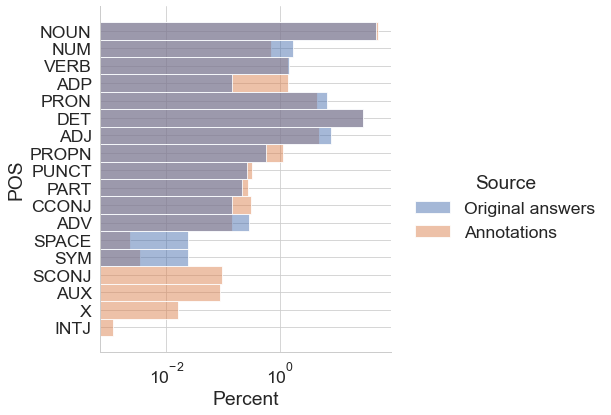

In [50]:
pos_df = pd.concat([
    pd.DataFrame(pd.Series((t.pos_
                            for instance in instances
                            for t in instance["label_subtree"] or []), name="POS")).assign(Source="Original answers"),
    pd.DataFrame(pd.Series((t.pos_
                            for instance in instances
                            for worker_spans in instance["annotation_subtrees"]
                            for span in worker_spans
                            for t in span or []), name="POS")).assign(Source="Annotations"),
]).reset_index(drop=True)

sns.displot(pos_df, y="POS", hue="Source", discrete=True, stat="percent", common_norm=False, height=6).set(xscale="log")
plt.gcf().savefig("POS_tags_per_label_type.pdf", bbox_inches="tight")

What are the top words in each category?

In [51]:
original_answer_pos_word_df = pd.DataFrame(((t.text.lower(), t.pos_)
                                            for instance in instances
                                            if instance["label_subtree"]
                                            for t in instance["label_subtree"]), columns=["Word", "POS"])
annotation_pos_word_df = pd.DataFrame(((t.text.lower(), t.pos_)
                                       for instance in instances
                                       for worker_spans in instance["annotation_subtrees"]
                                       for span in worker_spans
                                       if span is not None
                                       for t in span), columns=["Word", "POS"])

In [52]:
for pos in pos_df.POS.unique():
    print(f"POS tag {pos}")
    print("Original answer word counts:")
    display(original_answer_pos_word_df[original_answer_pos_word_df["POS"] == pos]["Word"].value_counts().head(10))
    print("Annotation word counts:")
    display(annotation_pos_word_df[annotation_pos_word_df["POS"] == pos]["Word"].value_counts().head(10))

POS tag NOUN
Original answer word counts:


man       136
woman      66
person     65
boy        46
people     45
girl       33
group      28
ball       19
music      18
front      17
Name: Word, dtype: int64

Annotation word counts:


man       1893
person    1321
woman      939
girl       651
people     640
boy        636
guy        568
child      540
group      438
kid        383
Name: Word, dtype: int64

POS tag NUM
Original answer word counts:


two      50
three    10
one       6
four      2
nine      1
45        1
Name: Word, dtype: int64

Annotation word counts:


two      364
one       85
2         73
three     27
3         14
four      14
4          7
1          5
2000       4
5          4
Name: Word, dtype: int64

POS tag VERB
Original answer word counts:


curling      3
lit          3
playing      2
hanging      2
dye          1
filling      1
boxed        1
shows        1
iron         1
crouching    1
Name: Word, dtype: int64

Annotation word counts:


wearing     67
playing     24
sitting     19
dancing     19
moving      17
doing       16
curling     15
holding     15
covered     13
standing    13
Name: Word, dtype: int64

POS tag ADP
Original answer word counts:


up          3
out         1
like        1
aboutthe    1
Name: Word, dtype: int64

Annotation word counts:


of      682
in      194
with    102
on       74
for      20
up       19
to       17
out      16
from     14
like     10
Name: Word, dtype: int64

POS tag PRON
Original answer word counts:


his        64
it         46
her        46
their      25
he         20
someone    19
them       18
she        10
they        7
himself     6
Name: Word, dtype: int64

Annotation word counts:


his          1156
her           876
someone       386
their         270
it            235
he            194
she           106
them          101
something      93
himself        79
Name: Word, dtype: int64

POS tag DET
Original answer word counts:


a          964
the        186
an          45
another     23
some        11
both         4
each         3
this         1
Name: Word, dtype: int64

Annotation word counts:


a          17555
the         6004
an          1283
some         272
another      211
this          46
both          18
no            17
all           16
each          12
Name: Word, dtype: int64

POS tag ADJ
Original answer word counts:


young        47
large        24
little       19
small        14
white         8
black         8
blue          7
older         7
several       6
different     6
Name: Word, dtype: int64

Annotation word counts:


young     494
little    158
black     147
small     143
white     141
other     107
large     106
blue       84
red        70
older      68
Name: Word, dtype: int64

POS tag PROPN
Original answer word counts:


christmas    1
mel          1
ninja        1
mutant       1
teenage      1
cosby        1
bill         1
perosn       1
frame        1
a            1
Name: Word, dtype: int64

Annotation word counts:


boy          29
female       21
man          19
lady         19
male         18
spanish      13
christmas    11
english      11
guy           8
easter        8
Name: Word, dtype: int64

POS tag PUNCT
Original answer word counts:


-    11
Name: Word, dtype: int64

Annotation word counts:


..    138
-     103
,      37
'       5
.       2
<       1
}       1
Name: Word, dtype: int64

POS tag PART
Original answer word counts:


's    9
Name: Word, dtype: int64

Annotation word counts:


to     115
's     115
not      4
n't      1
'        1
Name: Word, dtype: int64

POS tag CCONJ
Original answer word counts:


and    6
Name: Word, dtype: int64

Annotation word counts:


and    263
or       3
&        2
n        1
'        1
Name: Word, dtype: int64

POS tag ADV
Original answer word counts:


very         4
extremely    1
about        1
ornately     1
well         1
over         1
indoors      1
dimly        1
then         1
Name: Word, dtype: int64

Annotation word counts:


else       18
very       12
well        8
on          6
just        5
around      4
back        4
down        4
upside      3
outside     3
Name: Word, dtype: int64

POS tag SPACE
Original answer word counts:


     1
Name: Word, dtype: int64

Annotation word counts:


     2
Name: Word, dtype: int64

POS tag SYM
Original answer word counts:


/    1
Name: Word, dtype: int64

Annotation word counts:


/    3
Name: Word, dtype: int64

POS tag SCONJ
Original answer word counts:


Series([], Name: Word, dtype: int64)

Annotation word counts:


how      54
while    18
where     4
why       3
like      2
but       1
when      1
with      1
Name: Word, dtype: int64

POS tag AUX
Original answer word counts:


Series([], Name: Word, dtype: int64)

Annotation word counts:


is       30
being     8
are       6
be        4
was       4
can       4
's        4
did       3
has       3
do        2
Name: Word, dtype: int64

POS tag X
Original answer word counts:


Series([], Name: Word, dtype: int64)

Annotation word counts:


]           2
shim        1
,           1
perosn      1
compose     1
dadnce      1
younge      1
la          1
macarena    1
oragami     1
Name: Word, dtype: int64

POS tag INTJ
Original answer word counts:


Series([], Name: Word, dtype: int64)

Annotation word counts:


em    1
Name: Word, dtype: int64

### POS tag sequences
Let's look at the relative frequency of different tag sequences in the original answers and annotations.

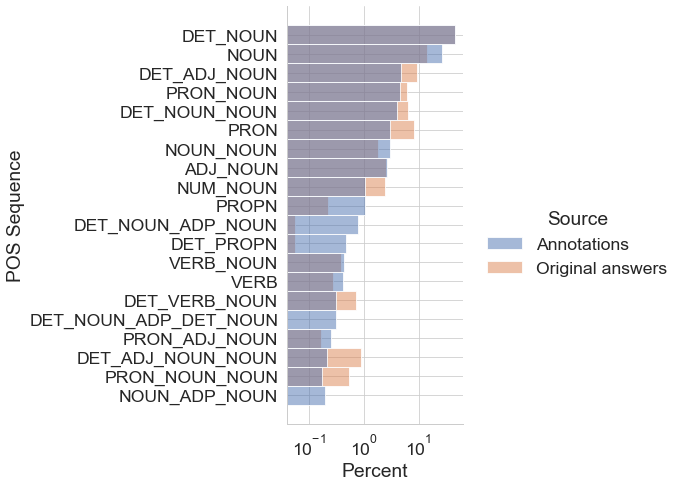

In [53]:
def get_pos_sequence(span: spacy.tokens.Span) -> str:
    return "_".join(x.pos_ for x in span)


pos_sequence_df = pd.concat([
    pd.DataFrame(((instance["label_subtree"].text.lower(), get_pos_sequence(instance["label_subtree"]))
                  for instance in instances
                  if instance["label_subtree"] is not None),
                 columns=["Word", "POS Sequence"]).assign(Source="Original answers"),
    pd.DataFrame(((span.text.lower(), get_pos_sequence(span))
                  for instance in instances
                  for worker_spans in instance["annotation_subtrees"]
                  for span in worker_spans
                  if span is not None), columns=["Word", "POS Sequence"]).assign(Source="Annotations"),
]).reset_index(drop=True)

pos_sequence_df["Count"] = pos_sequence_df.groupby("POS Sequence")["POS Sequence"].transform("count")
pos_sequence_df = pos_sequence_df.sort_values("Count", ascending=False)

top_pos_list = pos_sequence_df.groupby("POS Sequence").count().sort_values("Word", ascending=False).index[:20]
pos_sequence_top_df = pos_sequence_df[pos_sequence_df["POS Sequence"].isin(top_pos_list)]

sns.displot(pos_sequence_top_df, y="POS Sequence", hue="Source", discrete=True, stat="percent",
            height=7, common_norm=False).set(xscale="log")
plt.gcf().savefig("POS_tag_sequence_per_label_type.pdf", bbox_inches="tight")

Fewer pronouns for annotations than for labels. Similar levels of adjectives.

The most frequent words for the different sequences are:

In [54]:
for pos_sequence in top_pos_list[:10]:
    print(f"Testing the POS sequence {pos_sequence}.")

    pos_sequence_filtered_df = pos_sequence_df[pos_sequence_df["POS Sequence"] == pos_sequence]

    original_answer_word_counts = pos_sequence_filtered_df[
        pos_sequence_filtered_df.Source == "Original answers"].Word.value_counts()
    original_answer_word_counts /= original_answer_word_counts.sum()
    print(f"Original answer word counts:\n{original_answer_word_counts.head(10)}")

    annotation_word_counts = pos_sequence_filtered_df[
        pos_sequence_filtered_df.Source == "Annotations"].Word.value_counts()
    annotation_word_counts /= annotation_word_counts.sum()
    print(f"Annotation word counts:\n{annotation_word_counts.head(10)}")

Testing the POS sequence DET_NOUN.
Original answer word counts:
a man         0.125000
a person      0.066667
a woman       0.058333
a group       0.026190
a boy         0.022619
a girl        0.019048
a piece       0.014286
a table       0.011905
a child       0.011905
the camera    0.009524
Name: Word, dtype: float64
Annotation word counts:
a man       0.056135
a person    0.050818
a woman     0.027468
a guy       0.021318
a child     0.016366
a girl      0.015845
a boy       0.015793
a group     0.014385
a kid       0.014281
a lady      0.013864
Name: Word, dtype: float64
Testing the POS sequence NOUN.
Original answer word counts:
people      0.119231
front       0.065385
music       0.034615
dirt        0.019231
men         0.019231
kids        0.019231
man         0.019231
others      0.015385
children    0.015385
baskets     0.011538
Name: Word, dtype: float64
Annotation word counts:
people      0.034783
man         0.018743
kids        0.018394
music       0.013338
woman       0

- `PRON`: Annotations tend to use more specific pronoun phrases like `someone` or `something` rather than `it`, `he`, `she`.
- `DET_NOUN`: annotations are less gender-biased? Use `person` almost as much as `man`.

### Syntactic context
Do certain syntactic contexts (e.g. prepositions) tend to attract more or fewer unique answers than others?

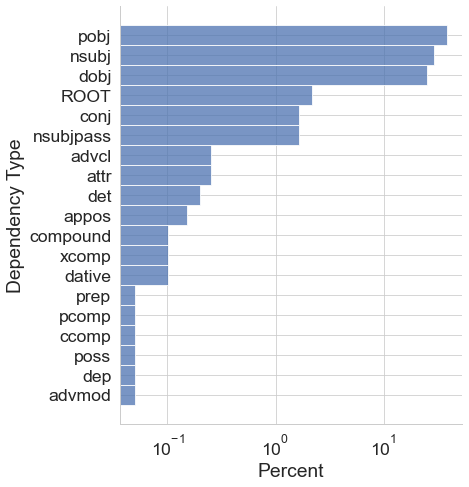

In [55]:
dep_df = pd.DataFrame({"Dependency Type": (instance["label_subtree"].root.dep_
                                           for instance in instances)})

dep_df["Count"] = dep_df.groupby("Dependency Type")["Dependency Type"].transform("count")
dep_df = dep_df.sort_values("Count", ascending=False)

sns.displot(dep_df, y="Dependency Type", discrete=True, stat="percent", height=7).set(xscale="log")
plt.gcf().savefig("dependency_category_counts.pdf", bbox_inches="tight")

Examples among the top:

In [56]:
for dep in dep_df["Dependency Type"].value_counts().index[:5]:
    print(f"sample data for dep = {dep}")

    i = 0
    for instance in instances:
        if instance["label_subtree"].root.dep_ == dep:
            print(f"Caption: '{instance['masked_caption']}'. Original answer: <{instance['label']}>")
            i += 1
            if i == 5:
                break
    print()

sample data for dep = pobj
Caption: 'A couple of people on stage playing music while in _____ of other people.'. Original answer: <front>
Caption: 'A stainless steel bowl of _____ is twisted in time to music, a hand reaches for a bite of fruit which a face eats and the face's body appears holding the bowl of fruit.'. Original answer: <cut up fruit>
Caption: 'Two girls are standing on _____ competing in a fencing dual.'. Original answer: <a mat>
Caption: 'A group of performers beat on _____ on stage.'. Original answer: <their drums>
Caption: 'An old man is outside hammering nails into _____.'. Original answer: <a stone block>

sample data for dep = nsubj
Caption: '_____ are dancing in the same fashion in unison with one another.'. Original answer: <Two boys>
Caption: '_____ laying down massages another with her feet while the other asks her to continue.'. Original answer: <A woman>
Caption: '_____ drops weight that he just clean and jerked.'. Original answer: <A man>
Caption: '_____ is 

### Dependency and the number of annotations per annotators

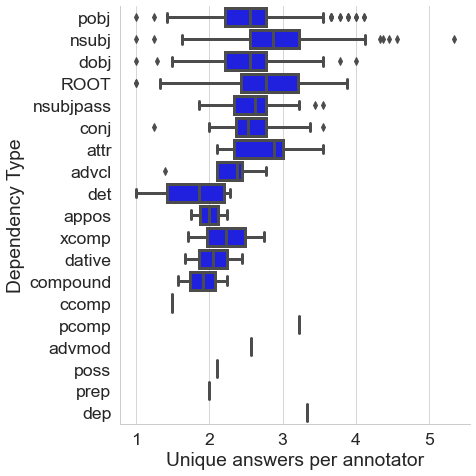

In [57]:
unique_answers_per_annotator_gen = (sum(len(worker_answers)
                                        for worker_answers in instance["annotations_norm"]) / len(
    instance["annotations_norm"])
                                    for instance in valid_instances)
mean_annotations_per_annotator_df = pd.DataFrame({"Unique answers per annotator": unique_answers_per_annotator_gen,
                                                  "Dependency Type": (instance["label_subtree"].root.dep_
                                                                      for instance in valid_instances)},
                                                 index=[instance["id"] for instance in valid_instances])

sns.catplot(data=mean_annotations_per_annotator_df, x="Unique answers per annotator", y="Dependency Type", color="blue",
            order=dep_df.groupby("Dependency Type").size().sort_values(ascending=False).index, kind="box", height=7)
plt.gcf().savefig("caption_annotation_counts_by_dependency_type.pdf", bbox_inches="tight")

Labels that appear after prepositions (`pobj`) and as direct objects (`dobj`) attract slightly fewer unique annotations than labels that appear as the subjects (`nsubj`) and in compound phrases (`compound`).

What's the agreement based on the dependency type?

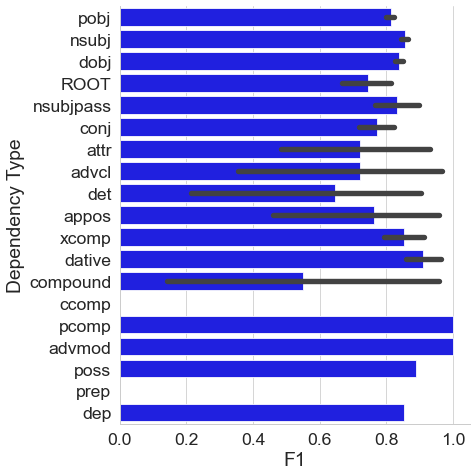

In [58]:
sns.catplot(data=mean_annotations_per_annotator_df.join(f1_scores_inter), x="F1", y="Dependency Type", color="blue",
            order=dep_df.groupby("Dependency Type").size().sort_values(ascending=False).index, kind="bar", height=7)

## Assess gender bias
Looking at the top-N words in different categories, we see that there may be cases where "male" words may be more frequent than "female" words.

Let's try to quantify this more.

In [59]:
import nltk
from nltk import WordNetLemmatizer

nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()
word_tokenizer = WordPunctTokenizer()

for instance in instances:
    instance["label_lemmas"] = [lemmatizer.lemmatize(t) for t in tokenizer.tokenize(instance["label_norm"])]
    instance["flat_annotation_lemmas"] = [lemmatizer.lemmatize(t)
                                          for worker_answers in instance["annotations_norm"]
                                          for answer in worker_answers
                                          for t in tokenizer.tokenize(answer)]

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [60]:
male_words = {"male", "man", "men", "boy", "guy", "his", "himself", "he", "him", "brother", "father", "son"}
female_words = {"woman", "girl", "lady", "her", "hers", "herself", "she", "female", "sister", "mother", "daughter"}
neutral_words = {"person", "people", "baby", "child", "children", "kid", "adult", "human", "parent", "sibling"}

### Get male/female word counts

In [61]:
original_answer_total_word_counts = pd.Series(
    word for instance in instances for word in instance["label_lemmas"]).value_counts()
annotation_total_word_counts = pd.Series(
    word for instance in instances for word in instance["flat_annotation_lemmas"]).value_counts()
n_original_answer_total_words = original_answer_total_word_counts.sum()
n_annotation_total_words = annotation_total_word_counts.sum()

In [62]:
original_answer_vocab = {y for x in instances for y in x["label_lemmas"]}
annotation_vocab = {y for x in instances for y in x["flat_annotation_lemmas"]}

for word_set_name, word_set in zip(["male", "female", "neutral"], [male_words, female_words, neutral_words]):
    print(f"Word set {word_set_name}:")
    original_answer_word_pct = original_answer_total_word_counts.loc[
                                   list(word_set & original_answer_vocab)].sum() / n_original_answer_total_words
    annotation_word_pct = annotation_total_word_counts.loc[
                              list(word_set & annotation_vocab)].sum() / n_annotation_total_words
    print(f"Original answer word = {original_answer_word_pct:1.3f}%")
    print(f"Annotation word = {annotation_word_pct:1.3f}%")
    print()

Word set male:
Original answer word = 0.109%
Annotation word = 0.092%

Word set female:
Original answer word = 0.062%
Annotation word = 0.059%

Word set neutral:
Original answer word = 0.060%
Annotation word = 0.067%

